# Data Wrangling
## WeRateDogs - Twitter API

This notebook contains data wrangling proccess; gathering, assesing and cleaning, of a dataset obtain from multiple sources. This proccess will allow us to perform investigations, drawing interpretations and visualiations based on consistent data.

## Gathering Data

We will cope with three different data sources:
* Tweets archive from a csv file provided by the Udacity Course.
* Dog Photos labeling by a machine learning algorithm available through csv uploaded in an accesible URL.
* All information related to each tweet; retweets, likes, commets, etc. from the Twitter API.

### Gathering Tweets Archive

In [156]:
import pandas as pd

In [157]:
tweets_archive = pd.read_csv("twitter-archive-enhanced.csv");

### Gathering Tweets Image Predictions

In [158]:
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url);
open('image-predictions.tsv', 'wb').write(response.content);

In [159]:
image_predictions = pd.read_csv("image-predictions.tsv", sep="\t")

### Gathering Tweets using Tweepy

In [160]:
import tweepy
import json

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
import sys
tweets = []
tweet_errors = []
tweetIds = tweets_archive.tweet_id.unique()
tweetIdsLength = tweetIds.shape[0]
for index, tweetId in enumerate(tweetIds):
    try:
        tweets.append(api.get_status(tweetId, tweet_mode='extended')._json)
    except Exception as e:
        tweet_errors.append(tweetId)
        sys.stdout.write("\rTweet Error - %d \n" % float(tweetId))
    sys.stdout.write("\r%.2f%%" % float(index*100/tweetIdsLength))

In [208]:
import numpy as np
tweets = np.array(tweets)
tweet_errors = np.array(tweet_errors)

In [209]:
tweet_errors.shape

(25,)

In [210]:
with open('tweet_json.txt', 'w') as outfile:
    for tweetJson in tweets:
        json.dump(tweetJson, outfile)
        outfile.write("\n")

In [211]:
with open('tweet_id_with_error.txt', 'w') as outfile:
    for tweetId in tweet_errors:
        outfile.write(str(tweetId))
        outfile.write("\n")

#### Reading From Stored Files

In [161]:
import json
filtered_tweets = []
with open('tweet_json.txt', 'r', encoding='utf-8') as file:
    for line in file:
        tweet = json.loads(line[:-1])
        filtered_tweets.append({
            'id': tweet['id'],
            'created_at': tweet["created_at"],
            'full_text': tweet["full_text"],
            'favorite_count': tweet["favorite_count"],
            'retweet_count': tweet["retweet_count"]
        })
tweepy_tweets = pd.DataFrame(filtered_tweets)

In [162]:
import json
tweets_with_errors = []
with open('tweet_id_with_error.txt', 'r', encoding='utf-8') as file:
    for line in file:
        tweetId = json.loads(line[:-1])
        tweets_with_errors.append(tweetId)

## Assesing Data

Now we will asses gathered data to identify **quality** and **tidiness** issues.

### Quality Issues

**tweets archive table**
* Some tweets couldn't be retrieved from Tweepy as they couln't be found so we will have to drop those tweets because we cannot not get likes and retweets from them and could not use them to fix rating_numerator and denominator values either.
* Tweets beyond August 1st, 2017 won't have image predictions and thus we will drop them as want to perform a full exploratory using both datasets. 
* Timestamp in 'tweets_archive' is of type string and should be DateTime to perform futures actions such is getting timestamps elpased time.
* Doggo, Flooofer, Pupper or Puppo are strings and should be either Categorical type or Boolean as values are from set of possible values and not a free valued string.
* Doggo, Flooofer, Pupper or Puppo columns contains values different from its dog stage; for instance under Doggo column why could find Floofer value. This is wrong and should be changed to None values.
* Some tweets has non-null values on retweeted_status_id, that means it is a retweet so we shouldnt take them into account to avoid multiple ratings on the same dog.
* Some rating_denominator are different from 10 that suggest that values are not perfectly retrieved from tweet text and we should check values from tweet got from Tweepy in order to fix this. In addition, if still there are any with denominator different from 10 we should drop them as they do not attached to a standarized rating.

**image_predictions table**
* P1, P2 and P3 labels predictions should be Categorical type instead of string type.
* Some dog image predictions doesn't contain a breed type on its labels so they shouldn't be considered as valid predictions. Those values are for instance: mud_turtle, umbrella, Indian_elephant, sports_car or tow_truck.
* Some dog image predictions are from retweets and thus multiple predictions are found from the same image_url. Predictions from retweets should be removed.

**All tables**
* Due to the fact that we got missing tweets fromo Tweepy because of retrieval erros, discarded image predictions because of non-predicted as dog images and that we tweets dropped because denominator values are incongruent, we have to assure that all tweets ID are available in final dataframes so we may perform a complete data exploration withoout  unreferenced data between dataframes.

### Tidiness Issues
List of tidiness issues identified:
* Dog stages are separated by columns and using one single colum named "dog_stage" as Categorical type would be more suitable.
* Also, we should use only two tables; one related to the tweet it self (id, created_at, likes and retweets) and other for the data related to each dog (image prediction label, dog_stage, dog_name and rating).

### Enhanced Tweets Archive

#### Visual Assesment

In [163]:
tweets_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


* Doggo, Flooofer, Pupper or Puppo columns contains values different from its dog stage; for instance under Doggo column why could find Floofer value. This is wrong and should be changed to None values.
* Dog stages are separated by columns and using one single colum named "dog_stage" as Categorical type would be more suitable.

#### Programatic Assesment

In [164]:
tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

* Timestamp in 'tweets_archive' is of type string and should be DateTime to perform futures actions such is getting timestamps elpased time.
* Doggo, Flooofer, Pupper or Puppo are strings and should be either Categorical type or Boolean as values are from set of possible values and not a free valued string.
* Some tweets has non-null values on retweeted_status_id, that means it is a retweet so we shouldnt take them into account to avoid multiple ratings on the same dog.

In [165]:
tweets_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


* Some rating_denominator are different from 10 that suggest that values are not perfectly retrieved from tweet text and we should check values from tweet got from Tweepy in order to fix this. In addition, if still there are any with denominator different from 10 we should drop them as they do not attached to a standarized rating.

In [166]:
tweets_archive[(tweets_archive.rating_denominator < 10) | (tweets_archive.rating_denominator > 10)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


### Image Dog Predictions

#### Visual Assesment

In [167]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


* Some dog image predictions doesn't contain a breed type on its labels so they shouldn't be considered as valid predictions. Those values are for instance: mud_turtle, umbrella, Indian_elephant, sports_car or tow_truck.

In [168]:
# Get how many image predictions do not predict a picture as a dog breed
image_predictions[(image_predictions.p1_dog == False) & (image_predictions.p2_dog == False) & (image_predictions.p3_dog == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


* Some dog image predictions are from retweets and thus multiple predictions are found from the same image_url. Predictions from retweets should be removed.

In [169]:
image_predictions[image_predictions.img_num > 1]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
312,671547767500775424,https://pbs.twimg.com/media/CVHRIiqWEAAj98K.jpg,2,Loafer,0.255088,False,platypus,0.090019,False,cowboy_boot,0.066536,False
315,671735591348891648,https://pbs.twimg.com/media/CVJ79MzW4AEpTom.jpg,2,stone_wall,0.271121,False,Irish_wolfhound,0.063078,True,poncho,0.048226,False
319,671768281401958400,https://pbs.twimg.com/media/CVKZsHtWwAA6gPj.jpg,2,Chihuahua,0.500373,True,French_bulldog,0.112796,True,Italian_greyhound,0.062893,True
345,672272411274932228,https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg,2,pug,0.914685,True,Norwegian_elkhound,0.014982,True,Siamese_cat,0.009221,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
2056,888554962724278272,https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg,3,Siberian_husky,0.700377,True,Eskimo_dog,0.166511,True,malamute,0.111411,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True


In [170]:
image_predictions.jpg_url.duplicated().sum()

66

In [171]:
image_predictions[(image_predictions.jpg_url.duplicated()) & (image_predictions.tweet_id.isin(tweets_archive[tweets_archive.retweeted_status_id.notnull()].tweet_id))].jpg_url.duplicated().sum()

0

All duplicated JPG_url in image_predictions are from retweets

#### Programatic Assesment

In [172]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* P1, P2 and P3 labels predictions should be Categorical type instead of string type.

In [173]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


Nothing seems odd

## Cleaning Data

### Define
#### Quality
1. Drop tweets from 'tweet_archive' that are not successfuly retrieved from Twitter API (tweepy_tweets).
* Change data type of 'timestamp' column of 'tweet_archive' to date type.
* Drop tweets beyond August 1st, 2017.
* Set 'doggo', 'floofer', 'pupper' and 'puppo' columns from 'tweet_archive' as Categorical Type.
* Change dog stage value to None in those cases where dog stage is set in the wrong column.
* Drop retweets from 'tweet_archive'.
* Set 'p1', 'p2' and 'p3' columns from 'image_predictions' to Categorical Type.
* Drop non-breed predictions from 'image_predictions'. Those which 'p1_dog', 'p2_dog' **and** 'p3_dog' with **False** values.
* Drop image predictions that comes from a retweet from 'image_predictions' or from tweets that couldn't be retrieved from tweepy.
* Reevaluate 'rating_numerator' and 'rating_denominator' parsing 'full_text' column of 'tweepy_tweets' and drop those with denominator above 10.
* Drop tweets that are not included in all datasets.

#### Tidiness
12. Melt dog stage ('doggo', 'floofer', 'pupper', 'puppo' columns) into a single column named 'dog_stage'.
* Elaborate a single dataframe containing 'tweet_id', 'text', 'created_at', 'favorite_count' and 'retweet_count' columns named tweets_master.
* Elaborate a single dataframe containing 'tweet_id', 'dog_name', 'dog_stage', 'rating_numerator', 'rating_denominator', 'p1', 'p1_conf', 'p2', 'p2_conf', 'p3', 'p3_conf' and 'jpg_url' columns named dog_metrics_master.

In [174]:
# Copy gathered dataframes to manipulate then mantaining originial data sources
tweets_archive_clean = tweets_archive.copy()
image_predictions_clean = image_predictions.copy()
tweepy_tweets_clean = tweepy_tweets.copy()

### Code and Tests

**\#1 Drop tweets from 'tweet_archive' that are not successfuly retrieved from Twitter API (tweepy_tweets).**

In [175]:
tweets_archive_clean.drop(tweets_archive_clean[tweets_archive_clean.tweet_id.isin(tweets_with_errors)].index, inplace=True)

In [176]:
# Test (none tweets_with_errors ids are in tweets_archive_clean)
assert not tweets_archive_clean.tweet_id.isin(tweets_with_errors).any()

**\#2 Change data type of 'timestamp' column of 'tweet_archive' to date type.**

In [177]:
tweets_archive_clean.timestamp = pd.to_datetime(tweets_archive_clean.timestamp)

In [178]:
# Test date type
assert tweets_archive_clean.timestamp.dtype.name == 'datetime64[ns, UTC]'

**\#4 Set 'doggo', 'floofer', 'pupper' and 'puppo' columns from 'tweet_archive' as Category Type.**

In [179]:
tweets_archive_clean.doggo = tweets_archive_clean.doggo.astype('category')
tweets_archive_clean.floofer = tweets_archive_clean.doggo.astype('category')
tweets_archive_clean.pupper = tweets_archive_clean.doggo.astype('category')
tweets_archive_clean.puppo = tweets_archive_clean.doggo.astype('category')

In [180]:
# Test date type
assert tweets_archive_clean.puppo.dtype == tweets_archive_clean.puppo.dtype == tweets_archive_clean.puppo.dtype == tweets_archive_clean.puppo.dtype == 'category'

**\#5 Change dog stage value to None in those cases where dog stage is set in the wrong column.**

In [181]:
def sanitizeDogStages(row):
    if (row["puppo"] != "puppo" and row["puppo"] != "None"):
        row["puppo"] = "None"
    if (row["doggo"] != "doggo" and row["doggo"] != "None"):
        row["doggo"] = "None"
    if (row["floofer"] != "floofer" and row["floofer"] != "None"):
        row["floofer"] = "None"
    if (row["pupper"] != "pupper" and row["pupper"] != "None"):
        row["pupper"] = "None"
        
    return row
    
tweets_archive_clean = tweets_archive_clean.apply(sanitizeDogStages, axis=1)   

**\#6 Drop retweets from 'tweet_archive'.**

In [182]:
tweets_archive_clean.drop(tweets_archive_clean[tweets_archive_clean.retweeted_status_id.notnull()].index, inplace = True)

In [183]:
# Test if there are any remaining retweets
assert tweets_archive_clean.retweeted_status_id.notnull().sum() == 0

**\#7 Set 'p1', 'p2' and 'p3' columns from 'image_predictions' to Categorical Type.**

In [184]:
image_predictions_clean.p1 = image_predictions_clean.p1.astype('category')
image_predictions_clean.p2 = image_predictions_clean.p2.astype('category')
image_predictions_clean.p3 = image_predictions_clean.p3.astype('category')

In [185]:
# Test data type
assert image_predictions_clean.p1.dtype.name == image_predictions_clean.p2.dtype.name == image_predictions_clean.p3.dtype.name == 'category'

**\#8 Drop non-breed predictions from 'image_predictions'. Those which 'p1_dog', 'p2_dog' and 'p3_dog' with False values.**

In [186]:
image_predictions_clean.drop(image_predictions_clean[(image_predictions_clean.p1_dog == False) & (image_predictions_clean.p2_dog == False) & (image_predictions_clean.p3_dog == False)].index, inplace=True)

In [187]:
# Test if there are some non-breed predictions in dataframe
assert image_predictions_clean[(image_predictions_clean.p1_dog == False) & (image_predictions_clean.p2_dog == False) & (image_predictions_clean.p3_dog == False)].shape[0] == 0

**\#9 Drop image predictions that comes from a retweet from 'image_predictions' or from tweets that couldn't be retrieved from tweepy.**

In [188]:
def comesFromRetweet(pred_tweet_id):
    tweetsFound = tweets_archive_clean[tweets_archive_clean.tweet_id == pred_tweet_id].shape[0]
    return tweetsFound == 0

image_predictions_clean.drop(image_predictions_clean[image_predictions_clean["tweet_id"].apply(comesFromRetweet)].index, inplace = True)

In [189]:
image_predictions_clean.drop(image_predictions_clean[image_predictions_clean.tweet_id.isin(tweets_with_errors)].index, inplace=True)

In [190]:
# Test if there are some predictions from tweets with errors or retweets
assert image_predictions_clean[image_predictions_clean.tweet_id.isin(tweets_with_errors)].shape[0] == 0
assert image_predictions_clean[image_predictions_clean["tweet_id"].apply(comesFromRetweet)].shape[0] == 0

**\#10 Reevaluate 'rating_numerator' and 'rating_denominator' parsing 'full_text' column of 'tweepy_tweets'.**

In [191]:
tweepy_tweets_clean["rating"] = tweepy_tweets_clean.full_text.str.extract(r'([0-9]+\/[0-9]+)')

In [192]:
tweepy_tweets_clean[["numerator", "denominator"]] = tweepy_tweets_clean.rating.str.split(pat="/", expand=True)

In [193]:
tweepy_tweets_clean["numerator"] = tweepy_tweets_clean["numerator"].astype(int)
tweepy_tweets_clean["denominator"] = tweepy_tweets_clean["denominator"].astype(int)

In [194]:
tweepy_tweets_clean.drop(tweepy_tweets_clean[tweepy_tweets_clean.denominator != 10].index, inplace = True)

In [195]:
assert not (tweepy_tweets_clean.denominator != 10).any()

**\#12 Melt dog stage ('doggo', 'floofer', 'pupper', 'puppo' columns) into a single column named 'dog_stage'.**

In [196]:
tweets_archive_clean["unknown_stage"] = (tweets_archive_clean.doggo == "None") & (tweets_archive_clean.floofer == "None") & (tweets_archive_clean.pupper == "None") & (tweets_archive_clean.puppo == "None")

In [197]:
tweets_archive_clean = pd.melt(tweets_archive_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name'])

In [198]:
# Drop duplicated values introduced in melting proccess
tweets_archive_clean.drop(tweets_archive_clean[(tweets_archive_clean.value == "None") | (tweets_archive_clean.value == False)].index, inplace=True)

In [199]:
def updateFalseDogStageToNone(dogStage):
    returnValue = dogStage
    if dogStage == True:
        returnValue = "None";
    return returnValue
tweets_archive_clean["value"] = tweets_archive_clean["value"].apply(updateFalseDogStageToNone)

In [200]:
tweets_archive_clean.rename(columns={"value": "dog_stage"}, inplace=True)

In [201]:
# Test reshaped columns
columns = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'variable', 'dog_stage']
assert tweets_archive_clean.columns.isin(columns).all()

**\#13 Elaborate a single dataframe containing 'tweet_id', 'created_at', 'text', 'favorite_count', 'retweet_count' columns named tweets_master.**


In [202]:
tweets_master = pd.merge(tweets_archive_clean, tweepy_tweets_clean, left_on="tweet_id", right_on="id", how='inner')
tweets_master.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'variable', 'id', 'full_text'], axis=1, inplace=True)

In [203]:
# Test final dataframe columns
columns = ['tweet_id', 'text', 'created_at', 'favorite_count', 'retweet_count',
       'rating', 'dog_stage', 'numerator', 'denominator']
assert tweets_master.columns.isin(columns).all()

**\#3 Drop tweets beyond August 1st, 2017.**

In [204]:
tweets_master.drop(tweets_master[tweets_master.created_at < "2018-08-01"].index, inplace=True)

In [205]:
# Test that there is no tweets beyond August 1st, 2017

In [206]:
assert tweets_master[tweets_master.created_at < "2017-08-01"].shape[0] == 0

**\#14 Elaborate a single dataframe containing 'tweet_id', 'dog_name', 'dog_stage', 'rating_numerator', 'rating_denominator', 'p1', 'p1_conf', 'p2', 'p2_conf', 'p3', 'p3_conf' and 'jpg_url' columns named dog_metrics_master.**

In [213]:
dog_metrics_master = pd.merge(image_predictions_clean, tweepy_tweets_clean, left_on="tweet_id", right_on="id", how='inner')

In [214]:
dog_metrics_master = pd.merge(dog_metrics_master, tweets_master, left_on="tweet_id", right_on="tweet_id", how='inner')

In [215]:
dog_metrics_master.drop(['img_num', 'p1_dog', 'p2_dog', 'p3_dog', 'id', 'created_at_x',
       'full_text', 'favorite_count_x', 'retweet_count_x', 'rating_x',
       'numerator_x', 'denominator_x', 'text', 'created_at_y',
       'favorite_count_y', 'retweet_count_y', 'rating_y', 'numerator_y',
       'denominator_y'], axis=1, inplace=True)

In [216]:
# Test final dataframe columns
columns = ['tweet_id', 'jpg_url', 'p1', 'p1_conf', 'p2', 'p2_conf', 'p3',
       'p3_conf', 'dog_stage']
assert dog_metrics_master.columns.isin(columns).all()

**\#11 Drop tweets that are not included in both datasets**

In [217]:
# Get inner join of tweets ids from all dataframes
aux_join = pd.merge(tweets_archive_clean, tweepy_tweets_clean, left_on="tweet_id", right_on="id", how="inner")
valid_tweets_id = pd.merge(aux_join, image_predictions_clean, on="tweet_id", how="inner").tweet_id.unique()

In [218]:
# Drop tweets that are not shared between dataframes
tweets_master.drop(tweets_master[~tweets_master.tweet_id.isin(valid_tweets_id)].index, inplace=True)
dog_metrics_master.drop(dog_metrics_master[~dog_metrics_master.tweet_id.isin(valid_tweets_id)].index, inplace=True)

In [219]:
# Check that all tweets exists in both databases
assert tweets_master.tweet_id.isin(dog_metrics_master.tweet_id).all()
assert tweets_master.shape[0] == dog_metrics_master.shape[0]

## Store Final Datasets

In [220]:
tweets_master.to_csv('twitter_archive_master.csv', index=False)
dog_metrics_master.to_csv('dog_metrics_master.csv', index=False)

## Analyzing Data

By analyzing the datasets we will try to answer the following questinos:
* What breeds has higher favorite counts?
* What breeds are the most common?
* Has dog rating influence on number of favorites?

In [221]:
import matplotlib.pyplot as plt

%matplotlib inline

tweets_master = pd.read_csv('twitter_archive_master.csv')
dog_metrics_master = pd.read_csv('dog_metrics_master.csv')

# Align data by tweet_id
df_expanded = pd.merge(tweets_master, dog_metrics_master, on="tweet_id", how="inner")

**What breeds are the most favorite?**

In [222]:
dogs_by_prediction = df_expanded.groupby(["p1"]).mean().sort_values(by="favorite_count", ascending=False)

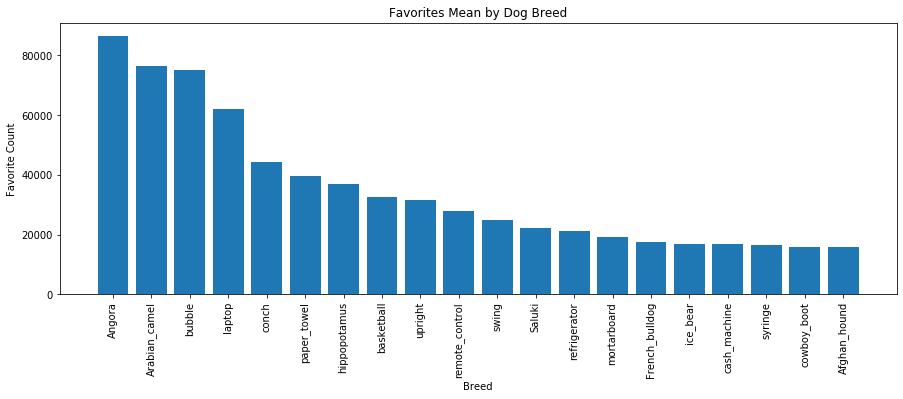

In [223]:
plt.figure(figsize=(15,5));
plt.xticks(rotation=90);
plt.title("Favorites Mean by Dog Breed")
plt.ylabel("Favorite Count")
plt.xlabel("Breed")
plt.bar(dogs_by_prediction.index[:20], dogs_by_prediction["favorite_count"][:20]);

In [224]:
df_expanded[df_expanded.p1 == "Angora"].values

array([[859196978902773760,
        "We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9",
        'None', 'Tue May 02 00:04:57 +0000 2017', 86632, 28691, '12/10',
        12, 10,
        'https://pbs.twimg.com/ext_tw_video_thumb/859196962498805762/pu/img/-yBpr4-o4GJZECYE.jpg',
        'Angora', 0.22421799999999997, 'malamute', 0.21616300000000002,
        'Persian_cat', 0.128383, 'None']], dtype=object)

As we can see there are certain breeds that usually get more favorites in average. However, it seems to have a particularity those with the highest values, in fact those results come from a single tweet. 

The top 10 would be:

In [225]:
dogs_by_prediction["favorite_count"][:10]

p1
Angora            86632.0
Arabian_camel     76365.0
bubble            74994.0
laptop            62188.0
conch             44249.0
paper_towel       39544.0
hippopotamus      36825.0
basketball        32456.0
upright           31731.0
remote_control    27998.0
Name: favorite_count, dtype: float64

**What breeds are the most common?**

In [226]:
dogs_by_breed = df_expanded.groupby(["p1"])["tweet_id"].count().sort_values(ascending=False)

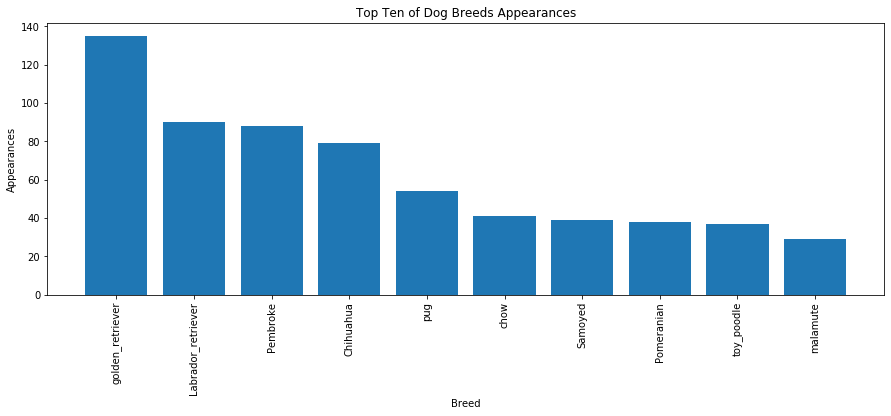

In [228]:
plt.figure(figsize=(15,5));
plt.xticks(rotation=90);
plt.title("Top Ten of Dog Breeds Appearances")
plt.ylabel("Appearances")
plt.xlabel("Breed")
plt.bar(dogs_by_breed.index[:10], dogs_by_breed[:10]);

As we may see most commonly detected breeds are not the same as those which get the higher amounts of favorites.

**Has dog rating influence on number of favorites?**

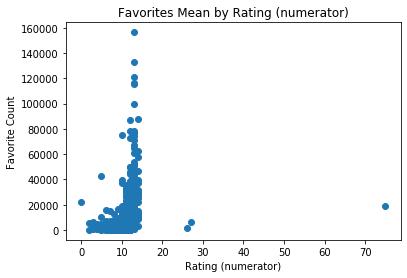

In [229]:
plt.title("Favorites Mean by Rating (numerator)")
plt.ylabel("Favorite Count")
plt.xlabel("Rating (numerator)")
plt.scatter(df_expanded["numerator"],df_expanded["favorite_count"]);

It seems to be a possitive correlation between favorite count and the rating of the dog picture. However, there are many dots with low values as well as high values for higher ratings. Let's have a look into means by labeling four different ratings using bins:

In [230]:
df_expanded.describe()["numerator"]

count    1662.000000
mean       10.885078
std         2.438781
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        75.000000
Name: numerator, dtype: float64

In [231]:
df_expanded["rating_tag"] = pd.cut(df_expanded.numerator, [0, 10, 11, 75], labels=["bad", "good", "excelent"])

In [232]:
tweets_by_rating_tag = df_expanded.groupby(["rating_tag"]).mean().sort_values(by="favorite_count")

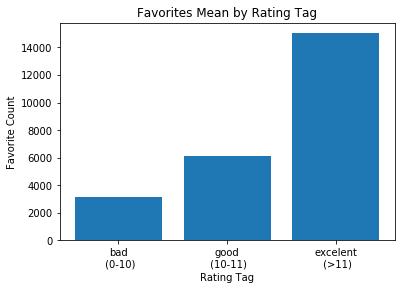

In [233]:
plt.title("Favorites Mean by Rating Tag")
plt.ylabel("Favorite Count")
plt.xlabel("Rating Tag")
plt.xticks(range(3), ["bad\n (0-10)","good\n (10-11)", "excelent\n (>11)"])
plt.bar(tweets_by_rating_tag.index, tweets_by_rating_tag["favorite_count"]);

## Conclusion

As we've seen in the results, we may expect to get better broadcast from tweets that shows certain breeds. However, after looking at the most common identified breeds we noticed that they dont coincide at all. In fact, a further look into each of the most shared and liked tweets reveals that the photo may not be so related to the results but the very content of the tweet (the text) is what is causing the singularity.
 
The most favorited dog breed is Angora but the picture itself it is low cuality and has a good rating. However the tweets has a ironic message: 'We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10'.

Thus, tweets with higher ratings are expected to has higher amount of favorites and retweets as it seems to represent an indicator of the whole tweet (text + image).

To be able to build a model of prediction from this tweets database a further analysis should be done on the tweet's text content.